TODO:
- Integrate NBD score [Complete]
- Full run [Complete]
- Show bins with images
- Integrate W&B Logging

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
import gc

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

#Install + import Weights and Biases
!pip install --upgrade wandb
import wandb

Random Seed:  999
     |████████████████████████████████| 1.4 MB 2.8 MB/s eta 0:00:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.8.35
    Uninstalling wandb-0.8.35:
      Successfully uninstalled wandb-0.8.35
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#wandb.init(config=config_default, project="DCGAN-nbd-test")

In [3]:
# Root directory for dataset
dataroot = "/kaggle/input/celeba-dataset/img_align_celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

#NBD Scoring

numTrainBatches = 50 #156

numTestBatches = 10 #39

#number of bins for NBD
k = 100

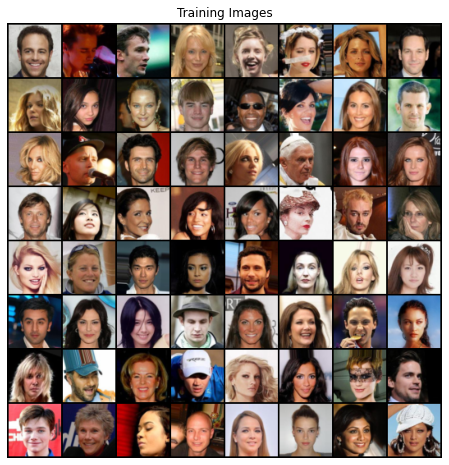

In [65]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
print(num_epochs)

1


In [12]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

start = time.time()
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        #For Testing
        if(i > 2):
            break
            
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0) 
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

end = time.time()
print("Time taken in seconds: ", end - start)

Starting Training Loop...


/opt/conda/conda-bld/pytorch_1587428398394/work/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


[0/1][0/1583]	Loss_D: 1.7771	Loss_G: 6.4739	D(x): 0.6863	D(G(z)): 0.6682 / 0.0028
Time taken in seconds:  2.3730716705322266


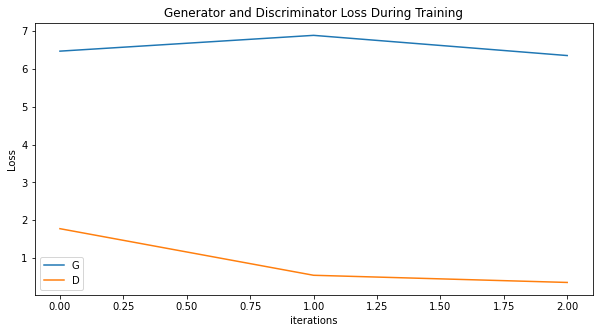

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

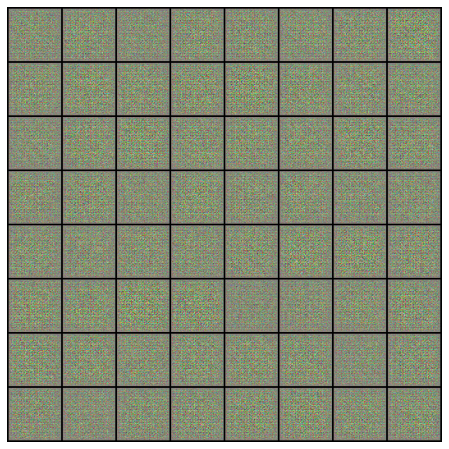

In [14]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

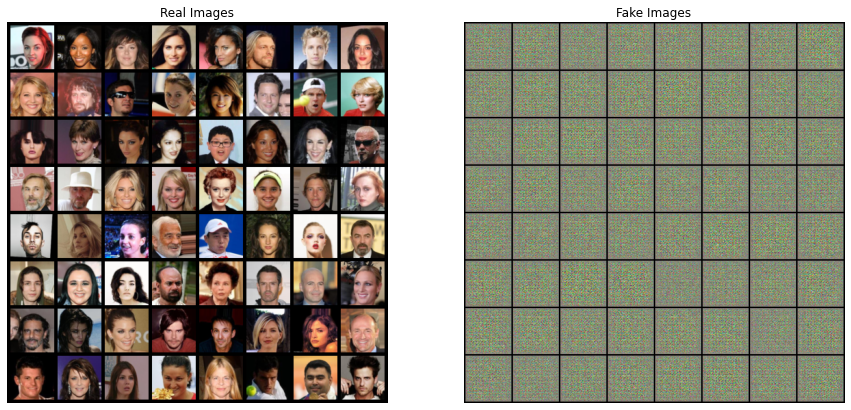

In [15]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

**NBD Testing**

In [96]:
import os
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import norm
from matplotlib import pyplot as plt
import pickle as pkl

class NDB:
    def __init__(self, training_data=None, number_of_bins=100, significance_level=0.05, z_threshold=None,
                 whitening=False, max_dims=None, cache_folder=None):
        """
        NDB Evaluation Class
        :param training_data: Optional - the training samples - array of m x d floats (m samples of dimension d)
        :param number_of_bins: Number of bins (clusters) default=100
        :param significance_level: The statistical significance level for the two-sample test
        :param z_threshold: Allow defining a threshold in terms of difference/SE for defining a bin as statistically different
        :param whitening: Perform data whitening - subtract mean and divide by per-dimension std
        :param max_dims: Max dimensions to use in K-means. By default derived automatically from d
        :param bins_file: Optional - file to write / read-from the clusters (to avoid re-calculation)
        """
        self.number_of_bins = number_of_bins
        self.significance_level = significance_level
        self.z_threshold = z_threshold
        self.whitening = whitening
        self.ndb_eps = 1e-6
        self.training_mean = 0.0
        self.training_std = 1.0
        self.max_dims = max_dims
        self.cache_folder = cache_folder
        self.bin_centers = None
        self.bin_proportions = None
        self.ref_sample_size = None
        self.used_d_indices = None
        self.results_file = None
        self.test_name = 'ndb_{}_bins_{}'.format(self.number_of_bins, 'whiten' if self.whitening else 'orig')
        self.cached_results = {}
        if self.cache_folder:
            self.results_file = os.path.join(cache_folder, self.test_name+'_results.pkl')
            if os.path.isfile(self.results_file):
                # print('Loading previous results from', self.results_file, ':')
                self.cached_results = pkl.load(open(self.results_file, 'rb'))
                # print(self.cached_results.keys())
        if training_data is not None or cache_folder is not None:
                bins_file = None
                if cache_folder:
                    os.makedirs(cache_folder, exist_ok=True)
                    bins_file = os.path.join(cache_folder, self.test_name+'.pkl')
                self.construct_bins(training_data, bins_file)

    def construct_bins(self, training_samples, bins_file):
        """
        Performs K-means clustering of the training samples
        :param training_samples: An array of m x d floats (m samples of dimension d)
        """

        if self.__read_from_bins_file(bins_file):
            return
        n, d = training_samples.shape
        k = self.number_of_bins
        if self.whitening:
            self.training_mean = np.mean(training_samples, axis=0)
            self.training_std = np.std(training_samples, axis=0) + self.ndb_eps

        if self.max_dims is None and d > 1000:
            # To ran faster, perform binning on sampled data dimension (i.e. don't use all channels of all pixels)
            self.max_dims = d//6

        whitened_samples = (training_samples-self.training_mean)/self.training_std
        d_used = d if self.max_dims is None else min(d, self.max_dims)
        self.used_d_indices = np.random.choice(d, d_used, replace=False)

        print('Performing K-Means clustering of {} samples in dimension {} / {} to {} clusters ...'.format(n, d_used, d, k))
        print('Can take a couple of minutes...')
        if n//k > 1000:
            print('Training data size should be ~500 times the number of bins (for reasonable speed and accuracy)')

        clusters = KMeans(n_clusters=k, max_iter=100, n_jobs=-1).fit(whitened_samples[:, self.used_d_indices])

        bin_centers = np.zeros([k, d])
        for i in range(k):
            bin_centers[i, :] = np.mean(whitened_samples[clusters.labels_ == i, :], axis=0)
        
        #print("Bin centers: ", bin_centers.shape)
        # Organize bins by size (largest bin -> smallest bin)
        label_vals, label_counts = np.unique(clusters.labels_, return_counts=True)
        bin_order = np.argsort(-label_counts)
        #print(bin_order)
        self.bin_proportions = label_counts[bin_order] / np.sum(label_counts)
        #print("Bin Proportions: ", self.bin_proportions)
        self.bin_centers = bin_centers[bin_order, :]
        #print("Bin centers after: ", self.bin_centers.shape)
        self.ref_sample_size = n
        self.__write_to_bins_file(bins_file)
        print('Done.')

    def evaluate(self, query_samples, model_label=None):
        """
        Assign each sample to the nearest bin center (in L2). Pre-whiten if required. and calculate the NDB
        (Number of statistically Different Bins) and JS divergence scores.
        :param query_samples: An array of m x d floats (m samples of dimension d)
        :param model_label: optional label string for the evaluated model, allows plotting results of multiple models
        :return: results dictionary containing NDB and JS scores and array of labels (assigned bin for each query sample)
        """
        n = query_samples.shape[0]
        query_bin_proportions, query_bin_assignments = self.__calculate_bin_proportions(query_samples)
        # print(query_bin_proportions)
        different_bins = NDB.two_proportions_z_test(self.bin_proportions, self.ref_sample_size, query_bin_proportions,
                                                    n, significance_level=self.significance_level,
                                                    z_threshold=self.z_threshold)
        ndb = np.count_nonzero(different_bins)
        js = NDB.jensen_shannon_divergence(self.bin_proportions, query_bin_proportions)
        results = {'NDB': ndb,
                   'JS': js,
                   'Proportions': query_bin_proportions,
                   'N': n,
                   'Bin-Assignment': query_bin_assignments,
                   'Different-Bins': different_bins}

        if model_label:
            print('Results for {} samples from {}: '.format(n, model_label), end='')
            self.cached_results[model_label] = results
            if self.results_file:
                # print('Storing result to', self.results_file)
                pkl.dump(self.cached_results, open(self.results_file, 'wb'))

        print('NDB =', ndb, 'NDB/K =', ndb/self.number_of_bins, ', JS =', js)
        return results

    def print_results(self):
        print('NSB results (K={}{}):'.format(self.number_of_bins, ', data whitening' if self.whitening else ''))
        for model in sorted(list(self.cached_results.keys())):
            res = self.cached_results[model]
            print('%s: NDB = %d, NDB/K = %.3f, JS = %.4f' % (model, res['NDB'], res['NDB']/self.number_of_bins, res['JS']))

    def plot_results(self, models_to_plot=None):
        """
        Plot the binning proportions of different methods
        :param models_to_plot: optional list of model labels to plot
        """
        K = self.number_of_bins
        w = 1.0 / (len(self.cached_results)+1)
        assert K == self.bin_proportions.size
        assert self.cached_results

        # Used for plotting only
        def calc_se(p1, n1, p2, n2):
            p = (p1 * n1 + p2 * n2) / (n1 + n2)
            return np.sqrt(p * (1 - p) * (1/n1 + 1/n2))

        if not models_to_plot:
            models_to_plot = sorted(list(self.cached_results.keys()))

        # Visualize the standard errors using the train proportions and size and query sample size
        train_se = calc_se(self.bin_proportions, self.ref_sample_size,
                           self.bin_proportions, self.cached_results[models_to_plot[0]]['N'])
        plt.bar(np.arange(0, K)+0.5, height=train_se*2.0, bottom=self.bin_proportions-train_se,
                width=1.0, label='Train$\pm$SE', color='gray')

        ymax = 0.0
        for i, model in enumerate(models_to_plot):
            results = self.cached_results[model]
            label = '%s (%i : %.4f)' % (model, results['NDB'], results['JS'])
            ymax = max(ymax, np.max(results['Proportions']))
            if K <= 70:
                plt.bar(np.arange(0, K)+(i+1.0)*w, results['Proportions'], width=w, label=label)
            else:
                plt.plot(np.arange(0, K)+0.5, results['Proportions'], '--*', label=label)
        plt.legend(loc='best')
        plt.ylim((0.0, min(ymax, np.max(self.bin_proportions)*4.0)))
        plt.grid(True)
        plt.title('Binning Proportions Evaluation Results for {} bins (NDB : JS)'.format(K))
        plt.show()

    def __calculate_bin_proportions(self, samples):
        if self.bin_centers is None:
            print('First run construct_bins on samples from the reference training data')
        assert samples.shape[1] == self.bin_centers.shape[1]
        n, d = samples.shape
        k = self.bin_centers.shape[0]
        D = np.zeros([n, k], dtype=samples.dtype)

        print('Calculating bin assignments for {} samples...'.format(n))
        whitened_samples = (samples-self.training_mean)/self.training_std
        for i in range(k):
            print('.', end='', flush=True)
            D[:, i] = np.linalg.norm(whitened_samples[:, self.used_d_indices] - self.bin_centers[i, self.used_d_indices],
                                     ord=2, axis=1)
        print()
        labels = np.argmin(D, axis=1)
        probs = np.zeros([k])
        label_vals, label_counts = np.unique(labels, return_counts=True)
        probs[label_vals] = label_counts / n
        return probs, labels

    def __read_from_bins_file(self, bins_file):
        if bins_file and os.path.isfile(bins_file):
            print('Loading binning results from', bins_file)
            bins_data = pkl.load(open(bins_file,'rb'))
            self.bin_proportions = bins_data['proportions']
            self.bin_centers = bins_data['centers']
            self.ref_sample_size = bins_data['n']
            self.training_mean = bins_data['mean']
            self.training_std = bins_data['std']
            self.used_d_indices = bins_data['d_indices']
            return True
        return False

    def __write_to_bins_file(self, bins_file):
        if bins_file:
            print('Caching binning results to', bins_file)
            bins_data = {'proportions': self.bin_proportions,
                         'centers': self.bin_centers,
                         'n': self.ref_sample_size,
                         'mean': self.training_mean,
                         'std': self.training_std,
                         'd_indices': self.used_d_indices}
            pkl.dump(bins_data, open(bins_file, 'wb'))

    @staticmethod
    def two_proportions_z_test(p1, n1, p2, n2, significance_level, z_threshold=None):
        # Per http://stattrek.com/hypothesis-test/difference-in-proportions.aspx
        # See also http://www.itl.nist.gov/div898/software/dataplot/refman1/auxillar/binotest.htm
        p = (p1 * n1 + p2 * n2) / (n1 + n2)
        se = np.sqrt(p * (1 - p) * (1/n1 + 1/n2))
        z = (p1 - p2) / se
        # Allow defining a threshold in terms as Z (difference relative to the SE) rather than in p-values.
        if z_threshold is not None:
            return abs(z) > z_threshold
        p_values = 2.0 * norm.cdf(-1.0 * np.abs(z))    # Two-tailed test
        return p_values < significance_level

    @staticmethod
    def jensen_shannon_divergence(p, q):
        """
        Calculates the symmetric Jensen–Shannon divergence between the two PDFs
        """
        m = (p + q) * 0.5
        return 0.5 * (NDB.kl_divergence(p, m) + NDB.kl_divergence(q, m))

    @staticmethod
    def kl_divergence(p, q):
        """
        The Kullback–Leibler divergence.
        Defined only if q != 0 whenever p != 0.
        """
        assert np.all(np.isfinite(p))
        assert np.all(np.isfinite(q))
        assert not np.any(np.logical_and(p != 0, q == 0))

        p_pos = (p > 0)
        return np.sum(p[p_pos] * np.log(p[p_pos] / q[p_pos]))



In [97]:
def test_ndb():  
    dim=100
    k=50
    n_train = k*100
    n_test = k*10

    train_samples = np.random.uniform(size=[n_train, dim])
    ndb = NDB(training_data=train_samples, number_of_bins=k, whitening=True)

    test_samples = np.random.uniform(high=1.0, size=[n_test, dim])
    results = ndb.evaluate(test_samples, model_label='Test')
    print(results['Bin-Assignment'])
    print(ndb.bin_centers)
    # test_samples = np.random.uniform(high=0.9, size=[n_test, dim])
    # ndb.evaluate(test_samples, model_label='Good')

    # test_samples = np.random.uniform(high=0.75, size=[n_test, dim])
    # ndb.evaluate(test_samples, model_label='Bad')

    # ndb.plot_results(models_to_plot=['Test', 'Good', 'Bad'])

In [75]:
#Get real samples (to reduce training time take 40% of original data - 80000 samples)

real_batches = []
for i, data in enumerate(dataloader, 0):
    
    if(i >= numTrainBatches):
        break
        
    real = data[0].numpy()
    real_batches.append(real)

real_batches = np.array(real_batches)

del dataloader
del netD
torch.cuda.empty_cache()
gc.collect()

print(len(real_batches))
#Display a sample
plt.imshow(np.transpose(real_batches[0][0], (1,2,0)))

# real_combined = real_batches[0]
# for i in range(1,len(real_batches)):
#     real_combined = np.concatenate((real_combined, real_batches[i]))
real_combined = real_batches.reshape(numTrainBatches*batch_size, nc, image_size, image_size)

NameError: name 'netD' is not defined

In [19]:

del real_batches
gc.collect()

2463

10


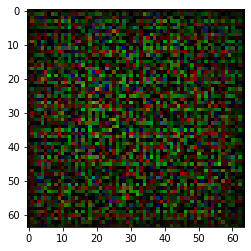

In [20]:
#Generate fake samples for testing (about 10% of total data - 20000 samples)

generated_batches = []
for i in range(numTestBatches):
    noise = torch.randn(batch_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise).detach().cpu().numpy()
    generated_batches.append(fake)

generated_batches = np.array(generated_batches)

print(len(generated_batches))
#Display a sample
plt.imshow(np.transpose(generated_batches[0][0], (1,2,0)))

del netG
torch.cuda.empty_cache()
gc.collect()

# gen_combined = generated_batches[0]
# for i in range(1,len(generated_batches)):
#     gen_combined = np.concatenate((gen_combined, generated_batches[i]))
gen_combined = generated_batches.reshape(numTestBatches*batch_size, nc, image_size, image_size)

In [21]:
del generated_batches
gc.collect()

2463

In [22]:
print(real_combined.shape)
print(gen_combined.shape)

(6400, 3, 64, 64)
(1280, 3, 64, 64)


In [23]:
#put into format to be fed into NBD
train_size = numTrainBatches*batch_size
test_size = numTestBatches*batch_size
dim = image_size*image_size*nc

train_samples = real_combined.reshape(train_size, dim)
test_samples = gen_combined.reshape(test_size, dim)
print(train_samples.shape)
print(test_samples.shape)


(6400, 12288)
(1280, 12288)


Performing K-Means clustering of 6400 samples in dimension 2048 / 12288 to 100 clusters ...
Can take a couple of minutes...
Done.
Calculating bin assignments for 1280 samples...
....................................................................................................
Results for 1280 samples from Test: NDB = 98 NDB/K = 0.98 , JS = 0.6710349571158001


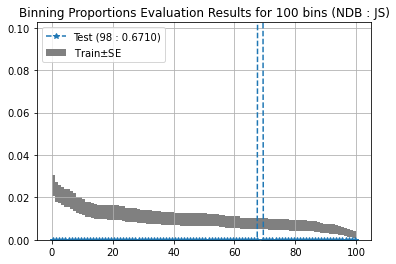

In [25]:
ndb = NDB(training_data=train_samples, number_of_bins=k, whitening=True)
results = ndb.evaluate(test_samples, model_label='Test')
ndb.plot_results(models_to_plot=['Test'])

In [37]:
#Sort smallest to largest bin
unique, counts = np.unique(results["Bin-Assignment"], return_counts=True)
zipped = list(zip(unique, counts))
zipped.sort(key=lambda tup: tup[1])

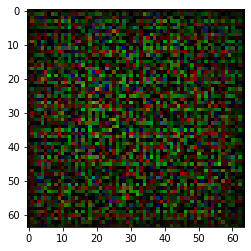

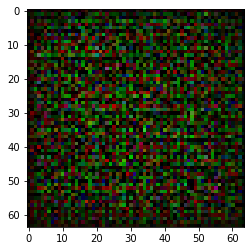

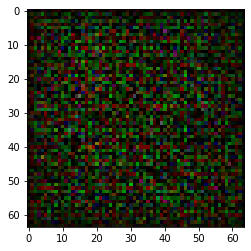

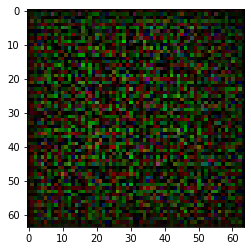

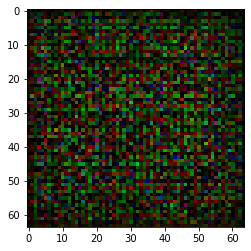

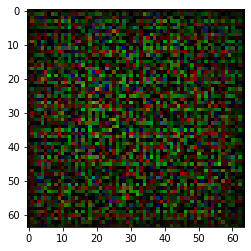

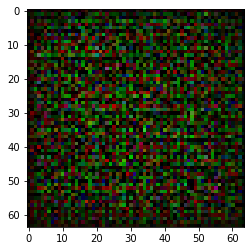

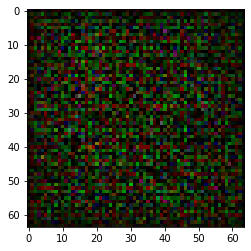

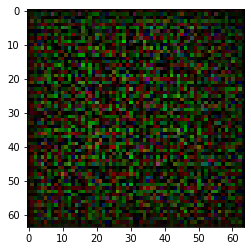

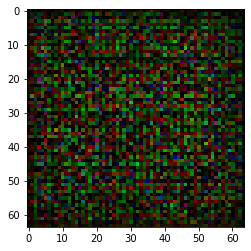

In [107]:
#Get biggest and smallest bins
smallest = zipped[0][0]
largest = zipped[len(zipped)-1][0]

smallest_indices = [i for i, x in enumerate(results["Bin-Assignment"]) if x == smallest]
largest_indices = [i for i, x in enumerate(results["Bin-Assignment"]) if x == largest]

#print out sample images
for i in range(len(smallest_indices[:5])):
    img = test_samples[smallest_indices[i]]
    img = img.reshape((nc, image_size, image_size))
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()
    
for i in range(len(largest_indices[:5])):
    img = test_samples[largest_indices[i]]
    img = img.reshape((nc, image_size, image_size))
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()

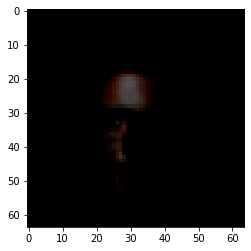

In [109]:
#print out the bin center image
sample_center = ndb.bin_centers[3]

sample_center = sample_center.reshape((nc, image_size, image_size))
plt.imshow(np.transpose(sample_center, (1,2,0)))